# Week 11 computer lab

### Aim: To identify and quantify linkages between climate drivers and Australian climate
 - What the spatial pattern of impacts is from a particular climate driver
 - What temporal variability there is in climate impacts (seasonal, random or otherwise)
 - How to use statistical testing to quantify the significance of climate driver impacts

### This lab will use Australian Rainfall from the gridded AWAP product from BOM, and the NINO34, DMI and SAM indices

Download these from the hard-drive in class or the following links (they're pretty small, ~140MB total)  
https://anu365-my.sharepoint.com/:u:/g/personal/u6955431_anu_edu_au/EUt3T43EjxNCvpYETIWsjX8BW2Ea8I99a1xWUQ3gAyqtLQ?e=leNPAv 
https://anu365-my.sharepoint.com/:u:/g/personal/u6955431_anu_edu_au/EQLqytPgmudMl1HqowaL-AoB-iVIorD70HFWQOeevJhvAg?e=SoC7uQ

AWAP precipitation is this data http://www.bom.gov.au/jsp/awap/rain/rmse_archive.jsp?map=totals&period=month&year=2024&month=5&day=14, only I've downloaded it as a netcdf from https://climexp.knmi.nl/select.cgi?id=someone@somewhere&field=awap_prcp_mo, and then masked out the ocean and fixed up the time axis.

Details of the climate indices' sources are in their file. I've tidied up the timestamps so they should align across all datasets.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats #Statistics library, useful for statistical testing

In [2]:
# Mess with a couple of matplotlib defaults for prettier plots
plt.figure() # You need to call plt first for the defaults to stick; I don't know why
plt.rcParams['hatch.linewidth']=0.5 # Smaller stippling obscures less of the underlying data
plt.rcParams['figure.dpi'] = 100 # This should be the default, but sometimes it isn't and produces weird figure sizes

<Figure size 640x480 with 0 Axes>

# Science example code
First, load in the datasets and remove the seasonal cycle, because we don't want this to confound our results

The groupby operation can be useful for manipulating data within a year, in this case subtracting the seasonal cycle. 

In [3]:
climate_drivers = xr.load_dataset('/Users/u6955431/Large_Datasets/climate_drivers.nc')
prcp = xr.load_dataset('/Users/u6955431/Large_Datasets/awapprcp_tidy.nc').prcp

#subtract seasonal cycle
prcp = prcp.groupby('time.month')-prcp.groupby('time.month').mean()
climate_drivers = climate_drivers.groupby('time.month')-climate_drivers.groupby('time.month').mean()

To find a link between NINO34 and Australian rainfall, the following few cells demonstrate ways of calculating a correlation. The simplest and fastest approach is to use the xarray native calculation, but this does not give an estimate of statistical significance.

CPU times: user 643 ms, sys: 150 ms, total: 794 ms
Wall time: 790 ms


/Users/u6955431/mambaforge/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/u6955431/mambaforge/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 0, 'longitude')

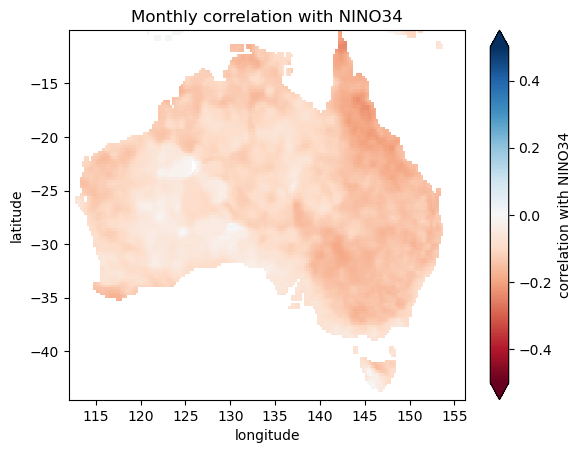

In [9]:
%%time
corr = xr.corr(climate_drivers.nino34,prcp,dim='time')

plt.title('Monthly correlation with NINO34')
plt.pcolormesh(prcp.lon,prcp.lat,corr,cmap='RdBu',vmin=-0.5,vmax=0.5)
plt.colorbar(label = 'correlation with NINO34',extend='both')
plt.ylabel('latitude')
plt.xlabel('longitude')

Alternately, we can calculate the correlation using scipy, to get a statistical significance as well. Scipy can't handle more than one timeseries at a time like xarray can, and the simplest way around this is to calculate correlation for each lat/lon individually in a for loop. This is much slower (30s on my laptop), because the scipy code doesn't have the same focus on speed as xarray.

In [5]:
%%time

#Copy the data structure from prcp by making an empty dataset full of zeros
corr_xr = xr.zeros_like(prcp.isel(time=0)).transpose('lon','lat',...) # Transpose dimension order so we know how
p_xr = xr.zeros_like(prcp.isel(time=0)).transpose('lon','lat',...)    # to fill it in


for i, lon in enumerate(prcp.lon):
    for j, lat in enumerate(prcp.lat):
        
        if np.isnan(prcp.sel(lat=lat,lon=lon,time='1950-01')):
            # Scipy doesn't like NaN, so if prcp is NaN just fill in a nan and skip the scipy bit
            corr_xr[i,j] = np.nan
            p_xr[i,j] = np.nan
        else:
            # Trim data to that which we want to use (this is where you would select specific seasons)
            # Here, I use data from all months of the year, but cut off data before 1950 that might be less reliable
            # and the precipitation dataset only goes to 2019
            X = climate_drivers.nino34.sel(time=slice('1950','2019'))
            Y = prcp.sel(lat=lat,lon=lon,time=slice('1950','2019'))
            
            # Calculate correlation coefficient and p value
            corr, p_value = scipy.stats.pearsonr(X, Y) # Calculate correlation coefficient and p value
            
            # Store these
            corr_xr[i,j] = corr
            p_xr[i,j] = p_value

corr_xr = corr_xr.transpose('lat','lon') # Transpose dimensions back where they were to minimise confusion
p_xr = p_xr.transpose('lat','lon')       # and minimise plotting complications

/Users/u6955431/mambaforge/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


CPU times: user 29.8 s, sys: 233 ms, total: 30 s
Wall time: 30.1 s


A third approach I present, mostly for curiosity, is below. This uses xarray to make scipy more efficient by spreading the calculation out over multiple cores of the laptop. It's much faster to run - 3.7s on my laptop, or 5 times faster. However, it probably took me longer to write  than I saved in computation time. It's worth knowing that there are magic tricks to speed up code if you need to crunch a lot of data, or run a calculation many times, but often the fastest code is the code _you_ can write fastest.  You don't need to understand the next cell for this lab, I'm just sharing it to show it is possible to speed up code when necessary.


In [7]:
%%time

X = climate_drivers.nino34.sel(time=slice('1950','2018'))
Y = prcp.sel(time=slice('1950','2018'))

Y = Y.where(~np.isnan(Y),0) # Replace NaN with zero to make scipy happy

corr_xr, p_xr = xr.apply_ufunc(scipy.stats.pearsonr, # function to make faster
                               X, 
                               Y,
                               input_core_dims=(('time',),('time',)), # dimensions NOT to split up (giving to function)
                             output_core_dims = ([],[],), # dimensions NOT to split up (coming from function). This is mostly here to indicate two things come out of the function
                             vectorize=True, # tell xarray that the function can't handle vectors and xarray has to do the vectorisation
                     )

/Users/u6955431/mambaforge/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


CPU times: user 3.52 s, sys: 41.1 ms, total: 3.56 s
Wall time: 3.56 s


Text(0.5, 0, 'longitude')

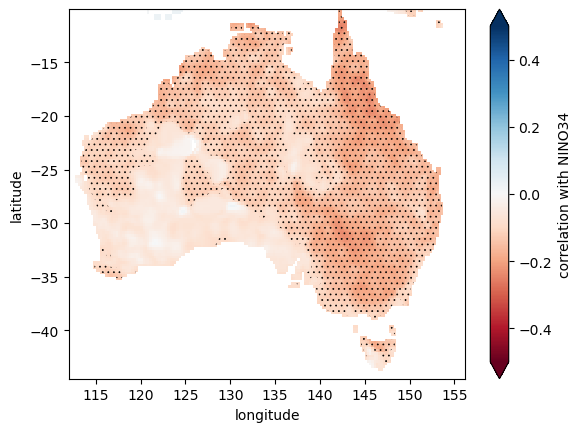

In [8]:
# Make pretty plots:
plt.pcolormesh(prcp.lon,prcp.lat,corr_xr,cmap='RdBu',vmin=-0.5,vmax=0.5)
plt.colorbar(label = 'correlation with NINO34',extend='both')
plt.contourf(prcp.lon,prcp.lat,p_xr,alpha=0,colors=('#555555',),levels=(0,0.01,),hatches = ('...',))
plt.ylabel('latitude')
plt.xlabel('longitude')

Some other useful things to know are how to temporally subset data, of which examples are below. If you want to trim data in a way not described here, ask Jemma/Nicola

In [10]:
prcp.sel(time=slice('1950','2018')) # prcp data from 1950-2018 inclusive
prcp.where(prcp['time.month'] == 1, drop = True) # prcp data from only January
prcp.where(prcp['time.season'] == 'JJA', drop = True) # prcp data from Austral winter only

prcp.groupby('time.year').mean() # Take the average within each year. Can be used in conjunction with seasonal subsetting, for example

<xarray.DataArray 'prcp' (year: 121, lat: 138, lon: 177)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 112.1 112.3 112.6 112.8 ... 155.4 155.6 155.9 156.1
  * lat      (lat) float32 -44.4 -44.15 -43.9 -43.65 ... -10.65 -10.4 -10.15
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2016 2017 2018 2019 2020

You can also use ```.sel``` to spatially subset data, e.g.

In [11]:
prcp.sel(lat = -20, lon=150, method = 'nearest')

<xarray.DataArray 'prcp' (time: 1452)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    lon      float32 150.1
    lat      float32 -19.9
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2020-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

## Q1. How is Australia impacted by \[pick a climate driver\]

a. Pick one of the other indices in the climate drivers dataset, either the Dipole Mode Index (DMI) of the Indian Ocean Dipole, or the Southern Annular Mode (SAM). What is the spatial pattern of correlations of Australian rainfall with this index? Include an indication of significance

b. If you correlate yearly averages of the index and Australian rainfall, how does this impact your correlations and statistical significance? In which circumstances might monthly or annual correlations be more useful?

c. How does the impact of this driver vary in different seasons? In what season does it have the strongest impact? Why might this be? You may find the [BOM summary of Australian Climate drivers](http://www.bom.gov.au/climate/about/) helpful, in addition to lecture material.

d. Compare to another climate driver (ENSO plots above, or the other of DMI/SAM with a classmate). In what regions is your chosen driver the most dominant?

e. How does the period of data used (e.g. 1950-2000, 1950-2020, 1900-1970) affect your results? Just pick one of your spatial maps to compare. What reasons might there be for any differences?

## Q2. Making a crude forecast from a single climate driver

The mean [NINO34 index forecast for October 2023](http://www.bom.gov.au/climate/enso/#tabs=Pacific-Ocean) is -0.7°C. For questions a-e, assume that this value has no associated uncertainty and use it to forecast October rainfall over the Wagga Wagga region. (If you want to do this exercise with any other "forecasted" value and/or any other climate driver, and/or any other region, go for it. It will work best where there is a strongish link between the location and climate driver, which is why I suggest Wagga.)

a. Scatter plot October Wagga Wagga rainfall against NINO34. What is the minimum and maximum rainfall anomaly in October? What general relationship can you see between Wagga Wagga October rainfall and NINO34? (hint: ```.sel``` in the example code may help you here)

b. Use ```scipy.stats.linregress``` (documentation is [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html)) to calculate a relationship between October Wagga Wagga rainfall and NINO34. This should give you a slope and intercept, which combine to a simple linear model of the form ```rainfall_anomaly = slope*NINO34+intercept```.

c. The slope output by scipy.stats.linregress will tell you how many mm/day is associated with a 1°C warming of NINO34. What is it? Does the p value indicate that it is significant? Enter your estimated rainfall anomaly into this week's wattle lab quiz.

d. By substituting NINO34 = -0.7°C into the linear model you have calculated from ```scipy.stats.linregress```, you can predict a rainfall anomaly associated with this SST anomaly. Is it above/below the mean? How does it compare to your minimum and maximum values?

e. To get an estimate of the uncertainty associated with this forecast, select all Octobers where NINO34 is -0.7$\pm$0.2°C. What is the minimum and maximum rainfalls in this range? How much does your forecast tell you, compared to the minimum and maximum of all years?

f. Questions a-d assumed a certain forecast of NINO34. What additional uncertainty could influence October rainfall this year? How might other climate drivers impact the forecast?

## Q3. OPTIONAL - Merging ideas
Can you apply the techniques in Q2 to produce a forecast map over Australia, using either a linear regression or composite?

## Work on your major assignment